In [277]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.io import loadmat
import datetime
#from quantopian.interactive.data.sentdex import sentiment
#from quantopian.pipeline.filters.morningstar import Q1500US

In [279]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='MAINUT5068DCQGJ9',output_format='pandas')
# Get json object with the intraday data and another with  the call's metadata

# get all available daily data (Netflix)
mydata, meta_data = ts.get_daily('AAPL',outputsize='full')

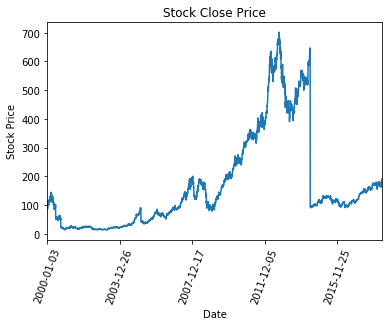

In [280]:
#data.head()
mydata['4. close'].plot()
plt.xticks(rotation=70)
plt.title('Stock Close Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.savefig('stock_full.png')

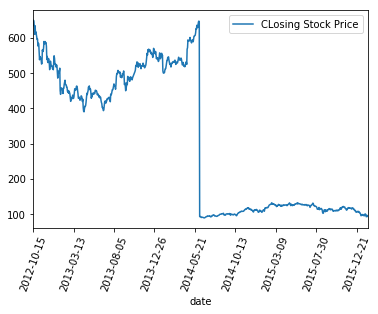

In [281]:
dataset = mydata.loc['2012-10-15':'2016-02-02']
stock_price = dataset['4. close'].values
stock = dataset.iloc[:,0]

df_stock = pd.DataFrame(data=stock_price,
                index=stock.index,
                 columns = ['CLosing Stock Price'])
df_stock.plot()
plt.xticks(rotation=70)
plt.savefig('stock_4years.png')

In [282]:
data = pd.ExcelFile("/home/sumesh/Documents/machine_learning/sentiment.xlsx")
sentiment = data.parse("AAPL")
val = sentiment.iloc[:,1]
datee = sentiment.iloc[:,0]
length = len(sentiment)

y=-1
ndata = np.zeros((829,1),dtype=float)
nindex = np.zeros((829,1),dtype=object)
for x in range(0,length):  
    for y in range(0,len(df_stock.index)):
        if datee[x].strftime('%Y-%m-%d') == df_stock.index[y]:
            ndata[y] = (float)(val[x])
            nindex[y] = datee[x].strftime('%Y-%m-%d')

df_sentiment = pd.DataFrame(data=ndata,
                index=nindex,
                 columns = ['Score'])


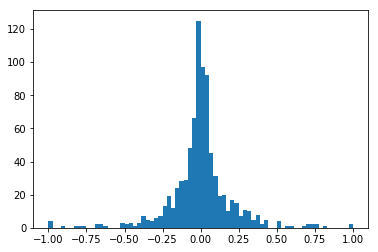

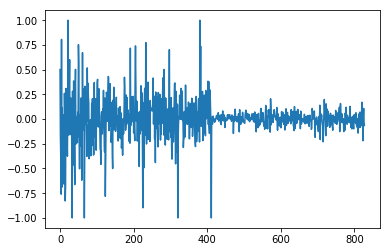

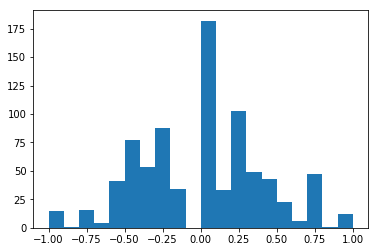

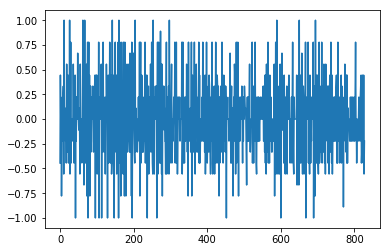

In [283]:
minstock = min(df_stock['CLosing Stock Price'].values)
maxstock = max(df_stock['CLosing Stock Price'].values)

delta_price = np.zeros((828,1))
delta_sentiment = np.zeros((828,1))
for x in range(0,828):
    delta_price[x] = df_stock['CLosing Stock Price'].values[x+1]-df_stock['CLosing Stock Price'].values[x]
    delta_sentiment[x] = df_sentiment['Score'].values[x+1]-df_sentiment['Score'].values[x]
    if delta_price[x] < -30:
        delta_price[x] = -30
    elif delta_price[x] > 30:
        delta_price[x] = 30


scaler = MinMaxScaler(feature_range=(-1, 1))
rescaledStock = scaler.fit_transform(delta_price.reshape(828,1))
rescaledScore = scaler.fit_transform(delta_sentiment.reshape(828,1))   

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)        
ax0.hist(rescaledStock, bins='auto')
plt.savefig('stock_hist.png')
#ax0.hist(delta_price, bins=[-50,-40,-30,-20,-15,-10,-5,-4,-3,-2,-1,0,1,2,3,4,5,10,15,20,30,40,50])
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(rescaledStock)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)        
ax2.hist(rescaledScore, bins='auto')
plt.savefig('sent_hist.png')
#ax0.hist(delta_price, bins=[-50,-40,-30,-20,-15,-10,-5,-4,-3,-2,-1,0,1,2,3,4,5,10,15,20,30,40,50])
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(rescaledScore)

minstock = min(delta_price)
maxstock = max(delta_price)

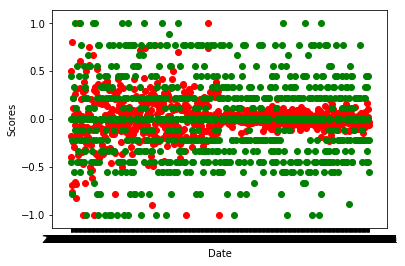

<Figure size 432x288 with 0 Axes>

In [284]:
plt.scatter(df_stock.index[0:828], rescaledStock, color='r')
plt.scatter(df_stock.index[0:828], rescaledScore, color='g')
plt.xlabel('Date')
plt.ylabel('Scores')
plt.show()
plt.savefig('scatter_plot.png')

In [285]:
# intial parameters
n_iter = len(rescaledStock)
sz = (n_iter) # size of array

beta = np.zeros(sz)
pred_change = np.zeros(sz)
K = np.zeros(sz)         # gain or blending factor
gamma = np.zeros(sz)



#z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)
z = rescaledStock

Q = 0.1 # process variance

# allocate space for arrays
beta_hat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
beta_hatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate


beta_hat[0] = rescaledStock[0]/rescaledScore[0]
R = 0.1**2 # estimate of measurement variance, change to see effect


P[0] = 1.0

for k in range(1,n_iter):
    # time update
    beta_hatminus[k] = beta_hat[k-1]
    Pminus[k] = P[k-1]+Q
    # measurement update
    K[k] = rescaledScore[k-1]/( rescaledScore[k-1]*rescaledScore[k-1]+P[k-1] )
    beta_hat[k] = beta_hatminus[k]+K[k]*(z[k]-beta_hatminus[k]*rescaledScore[k])
    P[k] = (1-K[k])*Pminus[k]


rescaledScore = rescaledScore.reshape(828)
#pred_change = np.multiply(rescaledStock,beta_hat)+np.random.normal(0,1,sz)
pred_change[0] = rescaledScore[0]*beta_hat[0]
pred_change[1] = 0.8*rescaledScore[1]*beta_hat[1]+0.2*rescaledScore[0]*beta_hat[1]
for i in range(2,828):
    pred_change[i] = 0.7*rescaledScore[i]*beta_hat[i]+0.2*rescaledScore[i-1]*beta_hat[i]+0.1*rescaledScore[i-2]*beta_hat[i]
#pred_change = pred_change + np.random.normal(0,1,sz)

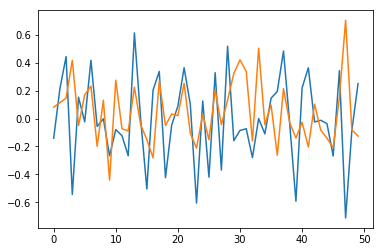

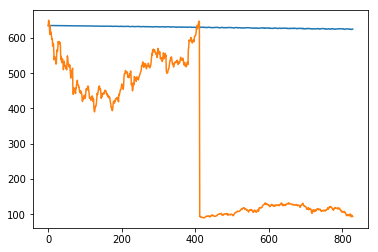

In [287]:
pred_stock = np.zeros(829)
pred_stock[0] = df_stock['CLosing Stock Price'].values[0]
    

for x in range(1,829):
    pred_stock[x] = pred_stock[x-1] + pred_change[x-1]

pred_change = pred_change.reshape(828)
rescaledStock = rescaledStock.reshape(828)


y = np.corrcoef(pred_change[250:300], rescaledStock[250:300])
pred_change = scaler.fit_transform(pred_change.reshape(828,1))
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)

ax4.plot(pred_change[250:300])
ax4.plot(rescaledStock[250:300])
plt.savefig('comparison.png')


stock_price = scaler.inverse_transform(pred_stock.reshape(829,1))
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(pred_stock)
ax5.plot(df_stock['CLosing Stock Price'].values)
